<a href="https://colab.research.google.com/github/slayerzeroa/KRX_Competition/blob/master/VKOSPI_231105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
%pip install pykrx --q
%pip install pandas_datareader --q
%pip install pyfolio --q
%pip install empyrical==0.3.4 --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfolio 0.9.2 requires empyrical>=0.5.0, but you have empyrical 0.3.4 which is incompatible.


In [108]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

from scipy import interpolate

from pandas import DataFrame, Series
import requests as re
from bs4 import BeautifulSoup
from pykrx import stock
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

import pyfolio as pf

In [109]:
# 금리 데이터 크롤링 함수
def crawling_interest_rates():
    data_dict = {'IRR_CD91':[],
                 'IRR_CALL':[]}
    label_list = ['IRR_CD91','IRR_CALL']
    Data = DataFrame()
    for label in label_list:
        date_list = []
        try:
            for i in range(1, 20):
                url = re.get('http://finance.naver.com/marketindex/interestDailyQuote.nhn?marketindexCd=%s&page=%s'%(label,i))
                url = url.content
                soup = BeautifulSoup(url,'html.parser')

                # 날짜 가져오기
                dates = soup.select('tr > td.date')

                try:
                    test = soup.find('tbody').find('tr').find('td',{'class':'num'}).text # .text가 에러를 반환하는가?
                except:
                    break

                for date in dates:
                    date_list.append(date.text.strip())

                rates = soup.find('tbody').find_all('tr')
                for rate in rates:
                    data_dict[label].append(rate.find('td',{'class':'num'}).text.strip())

        except:
            print('Error')

        temp_dataframe = DataFrame(data_dict[label], index = date_list)
        Data = pd.merge(Data,temp_dataframe,how = 'outer', left_index = True, right_index = True)

    Data.columns = ['CD91일', '콜금리']

    Data.index = pd.to_datetime(Data.index)
    return Data

In [110]:
# 금리 interpolation 함수
def rf_inter(mydate:datetime ,near_date_diff, next_date_diff, df):
    # 금리 interpolation
    my_data = df[df.index==mydate]
    x = [1, 91]
    y = [float(my_data['콜금리']), float(my_data['CD91일'])]

    spline_func = interpolate.CubicSpline(x, y)

    y1 = float(spline_func(near_date_diff)) / (60*24*365)
    y2 = float(spline_func(next_date_diff) / (60*24*365))
    return [y1, y2]

In [111]:
rate_df = pd.read_csv('rf_rate.csv', index_col=0)
rate_df
rate_df.index = pd.to_datetime(rate_df.index)

In [112]:
# 매주 옵션 만기일
# 월요일은 0, 목요일은 3
def nth_weekday(the_date, week_day):
    the_date += timedelta(days=1)
    while the_date.weekday() != week_day:
        the_date += timedelta(days=1)
    return the_date

# 근주물 옵션 만기일 구하기
def get_near_due(mydate:datetime)->datetime:
    # 목요일이 near term
    duedate_t = [0, 1, 2]
    # 월요일이 near term
    duedate_m = [3, 4, 5, 6]

    if mydate.weekday() in duedate_t:
      thisweek_duedate = nth_weekday(mydate, 3)
    else:
      thisweek_duedate = nth_weekday(mydate, 0)

    return thisweek_duedate

# 원주물 옵션 만기일 구하기
def get_next_due(mydate:datetime)->datetime:
    # 목요일이 near term
    duedate_t = [0, 1, 2]
    # 월요일이 near term
    duedate_m = [3, 4, 5, 6]

    if mydate.weekday() in duedate_m:
      mydate += timedelta(days=4)
      thisweek_duedate = nth_weekday(mydate, 3)
    else:
      mydate += timedelta(days=4)
      thisweek_duedate = nth_weekday(mydate, 0)

    return thisweek_duedate


# 날짜 차이 구하기
def date_diff(now, future):
  gap = future - now
  return gap.days

In [113]:
# following_two_cutoff 함수
def following_two_cutoff(data: pd.DataFrame):
  filter = data['Strike_Price_Diff'] < 7.5
  filter = list(filter)
  center = int(len(filter) / 2)
  flag = True
  while center != 0:
    if filter[center] == False:
      filter[center] = flag
      flag = False
    else:
      filter[center] = flag
    center -= 1

  center = int(len(filter) / 2)
  flag = True
  while center != (len(filter)-1):
    if filter[center] == False:
      flag = False
    filter[center] = flag
    center += 1

  return filter

# Cutoff 함수
def cutoff(data: pd.DataFrame, underlying):
  if data['Option_Type'].unique() == 'C':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) > underlying]
  if data['Option_Type'].unique() == 'P':
    data_cutoff = data[following_two_cutoff(data)]
    data_cutoff = data_cutoff[data_cutoff['Strike_Price'].astype(float) < underlying]
  return data_cutoff

In [114]:
def cal_vix(t: datetime, rate_df: pd.DataFrame):
  # try:
    # 기초자산 가격
    # kospi 200
    df = stock.get_index_ohlcv_by_date(t, t, "1028")
    underlying = (float(df.종가))

    # 목요일 만기 위클리 옵션 데이터
    option_data_t = stock.get_future_ohlcv(t, 'KRDRVOPWKI')

    # 월요일 만기 위클리 옵션 데이터
    option_data_m = stock.get_future_ohlcv(t, 'KRDRVOPWKM')

    option_data_t.dropna(axis = 1, how='all', inplace=True)
    option_data_t.dropna(axis = 0, how='any', inplace=True)
    option_data_m.dropna(axis = 1, how='all', inplace=True)
    option_data_m.dropna(axis = 0, how='any', inplace=True)

    near_date = get_near_due(t)
    next_date = get_next_due(t)

    near_date_diff = date_diff(t, near_date)
    next_date_diff = date_diff(t, next_date)

    rates = rf_inter(t, near_date_diff, next_date_diff, rate_df)

    Nt=[60*24*near_date_diff, 60*24*next_date_diff]		#minutes
    T=[Nt[0]/(60*24*365), Nt[1]/(60*24*365)]	#years

    if near_date.weekday() == 0:
      near_option_data = option_data_m
      next_option_data = option_data_t
    else:
      near_option_data = option_data_t
      next_option_data = option_data_m

    near_term_option = pd.DataFrame()

    near_option_data['Strike_Price'] = near_option_data['종목명'].str[-5:]
    near_option_data['Option_Type'] = near_option_data['종목명'].str[-14]

    near_data = []
    for i in near_option_data.Strike_Price:
      check = near_option_data[near_option_data.Strike_Price == i]
      if len(check) == 2:
        input_data = []
        # [Strike Price, Call Close, Put Close, Difference]
        input_data.append(float(check['Strike_Price'].unique()))
        input_data.append(check['종가'].to_list()[0])
        input_data.append(check['종가'].to_list()[1])
        input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
        if input_data not in near_data:
          near_data.append(input_data)
      else:
        pass

    near_term_option = pd.concat([near_term_option, pd.DataFrame(near_data)])
    near_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
    near_term_option = near_term_option[(near_term_option['Call']!=0) & (near_term_option['Put']!=0)]

    next_term_option = pd.DataFrame()

    next_option_data['Strike_Price'] = next_option_data['종목명'].str[-5:]
    next_option_data['Option_Type'] = next_option_data['종목명'].str[-14]

    # 월, 목 옵션 동시 존재 에러 해결
    # 예시 월요일에는 월요일 만기 옵션이 두 종류 존재 (오늘 만기, 다음주 만기)
    # 다음주 만기 옵션 데이터만 남기기 (롤오버)
    next_option_data['Select'] = (next_option_data['종목명'].str[-13:-8] + next_option_data['종목명'].str[-7:-6]).astype(int)
    next_option_data = next_option_data[next_option_data['Select'] == next_option_data['Select'].max()]

    next_data = []
    for i in next_option_data.Strike_Price:
      check = next_option_data[next_option_data.Strike_Price == i]
      if len(check) == 2:
        input_data = []
        # [Strike Price, Call Close, Put Close, Difference]
        input_data.append(float(check['Strike_Price'].unique()))
        input_data.append(check['종가'].to_list()[0])
        input_data.append(check['종가'].to_list()[1])
        input_data.append(abs(check['종가'].to_list()[0]-check['종가'].to_list()[1]))
        if input_data not in next_data:
          next_data.append(input_data)
      else:
        pass

    next_term_option = pd.concat([next_term_option, pd.DataFrame(next_data)])
    next_term_option.columns = ['Strike_Price', 'Call', 'Put', 'Difference']
    next_term_option = next_term_option[(next_term_option['Call']!=0) & (next_term_option['Put']!=0)]

    F1_data = near_term_option[near_term_option['Difference'] == near_term_option['Difference'].min()]
    F2_data = next_term_option[next_term_option['Difference'] == next_term_option['Difference'].min()]

    F1 = float(F1_data['Strike_Price'] + math.exp(rates[0] * T[0]) * (F1_data['Call'] - F1_data['Put']))
    F2 = float(F2_data['Strike_Price'] + math.exp(rates[1] * T[1]) * (F2_data['Call'] - F2_data['Put']))

    K_0_1 = near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference == near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)].Difference.min()
    K_0_1 = float(near_term_option[(near_term_option['Strike_Price'].astype(float) - F1 < 1)][K_0_1].Strike_Price)
    K_0_2 = next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference == next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)].Difference.min()
    K_0_2 = float(next_term_option[(next_term_option['Strike_Price'].astype(float) - F2 < 1)][K_0_2].Strike_Price)

    near_option_data_call = near_option_data[near_option_data['Option_Type'] == 'C']
    near_option_data_put = near_option_data[near_option_data['Option_Type'] == 'P']
    next_option_data_call = next_option_data[next_option_data['Option_Type'] == 'C']
    next_option_data_put = next_option_data[next_option_data['Option_Type'] == 'P']

    near_option_data_call['Strike_Price_Diff'] = near_option_data_call['Strike_Price'].astype(float).diff()
    near_option_data_put['Strike_Price_Diff'] = near_option_data_put['Strike_Price'].astype(float).diff()
    next_option_data_call['Strike_Price_Diff'] = next_option_data_call['Strike_Price'].astype(float).diff()
    next_option_data_put['Strike_Price_Diff'] = next_option_data_put['Strike_Price'].astype(float).diff()

    near_call = cutoff(near_option_data_call, underlying)
    near_put = cutoff(near_option_data_put, underlying)
    next_call = cutoff(next_option_data_call, underlying)
    next_put = cutoff(next_option_data_put, underlying)
    near_call['Contribution_by_Strike'] = (2.5/(near_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_call['종가']
    near_put['Contribution_by_Strike'] = (2.5/(near_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[0] * T[0]) * near_put['종가']
    next_call['Contribution_by_Strike'] = (2.5/(next_call['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_call['종가']
    next_put['Contribution_by_Strike'] = (2.5/(next_put['Strike_Price'].astype(float).pow(2))) * math.exp(rates[1] * T[1]) * next_put['종가']
    near = pd.concat([near_call, near_put])
    next = pd.concat([next_call, next_put])
    sigmasquared_1 = (2/T[0])*near['Contribution_by_Strike'].sum() - (1/T[0])*((F1/K_0_1)-1)**2
    sigmasquared_2 = (2/T[1])*next['Contribution_by_Strike'].sum() - (1/T[1])*((F2/K_0_2)-1)**2
    N30 = 60*24*5
    N365 = 60*24*365
    VIX = 100 * np.sqrt((T[0]*sigmasquared_1*((Nt[1]-N30)/(Nt[1]-Nt[0]))+T[1]*sigmasquared_2*((N30-Nt[0])/(Nt[1]-Nt[0])))*(N365/N30))
    return VIX
  # except Exception as e:
  #   print('Error')
  #   print(e)
  #   return None

In [115]:
# t = '20231101'
# t = datetime.strptime(t, '%Y%m%d')

# vix = cal_vix(t, rate_df)
# vix

In [116]:
vix_df = pd.read_csv("vix.csv")
vix_df = vix_df.set_index('Date')
vix_df.index = pd.to_datetime(vix_df.index)
vix_df.columns = ['w_vix']

In [117]:
date_list = list(vix_df.index)
monthly_vix_list = []
for date in date_list:
  monthly_vix_list.append(stock.get_future_ohlcv(date, 'KRDRVFUVKI')['현물가'][0])

In [118]:
vix_df['vix'] = monthly_vix_list

In [ ]:
# import warnings

# # 오류 경고 무시하기
# warnings.filterwarnings(action='ignore')


# vix_list = []
# date_list = []
# t = '20230801'
# t = datetime.strptime(t, '%Y%m%d')
# for i in range(120):
#   try:
#     vix = cal_vix(t, rate_df)
#     vix_list.append(vix)
#     date_list.append(t)
#     t += timedelta(days=1)
#   except:
#     t += timedelta(days=1)

# vix_df = pd.DataFrame([date_list, vix_list]).T
# vix_df.columns = ['Date', 'w_vix']
# vix_df.style.set_precision(10)

In [120]:
df = data.get_data_yahoo('^KS11')

df = pd.merge(
    vix_df, df['Adj Close'], how="left", left_index=True, right_index=True
    )
df.columns = ['w_vix', 'vix', 'kospi']

df['w_vix_returns'] = df['w_vix'].pct_change()
df['vix_returns'] = df['vix'].pct_change()
df['kospi_returns'] = df['kospi'].pct_change()

df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


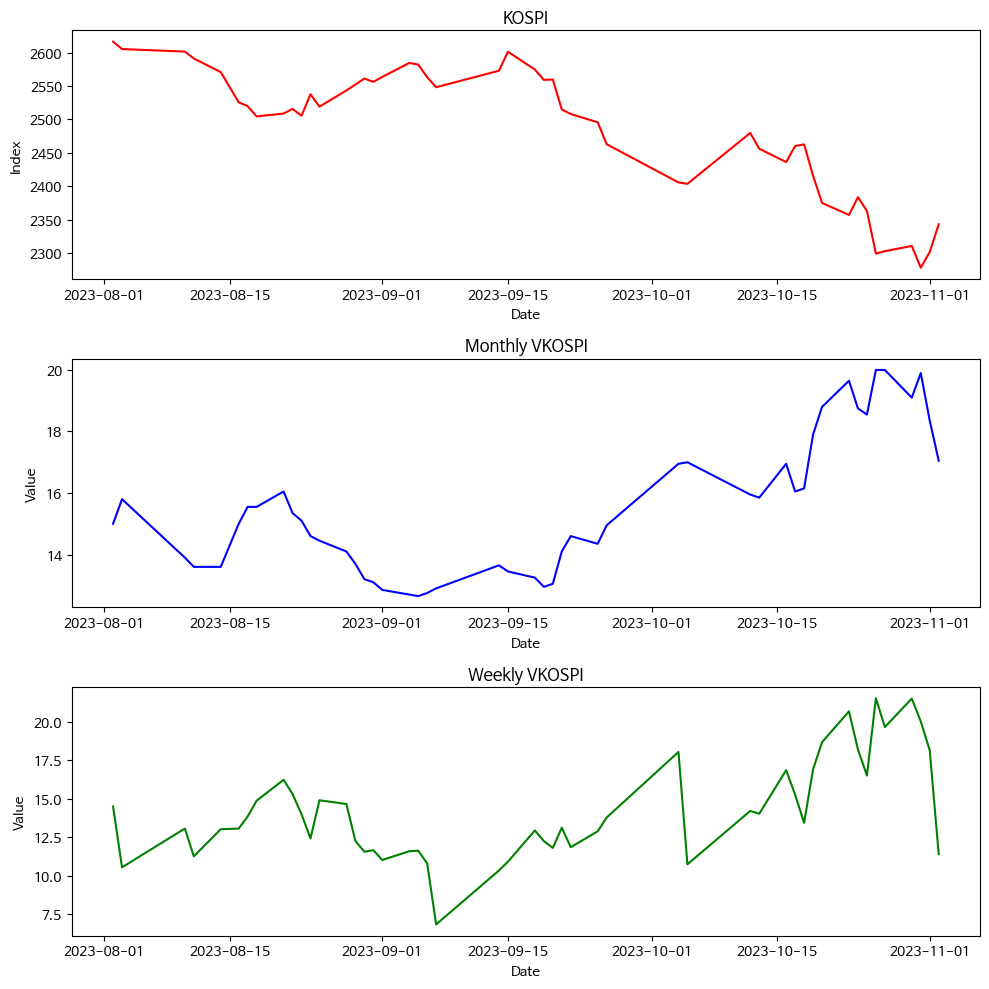

In [166]:
# plt.subplot(3, 1, 1)                # nrows=2, ncols=1, index=1
# plt.plot(df.index, df['kospi'])
# plt.title('KOSPI')
# plt.xlabel('Date')
# plt.ylabel('Index')

# plt.subplot(3, 1, 2)                # nrows=2, ncols=1, index=2
# plt.plot(df.index, df['vix'])
# plt.title('Monthly VKOSPI')
# plt.xlabel('Date')
# plt.ylabel('Value')


# plt.subplot(3, 1, 3)                # nrows=2, ncols=1, index=2
# plt.plot(df.index, df['w_vix'])
# plt.title('Weekly VKOSPI')
# plt.xlabel('Date')
# plt.ylabel('Value')

# # # plt.plot(left_merged['ST_VIX'])
# # plt.plot(left_merged['Adj Close'])

# plt.show()


fig, ax = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout()

#define data


#create subplots
ax[0].plot(df.index, df['kospi'], color='red')
ax[0].set_title('KOSPI')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Index')

ax[1].plot(df.index, df['vix'], color='blue')
ax[1].set_title('Monthly VKOSPI')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Value')

ax[2].plot(df.index, df['w_vix'], color='green')
ax[2].set_title('Weekly VKOSPI')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Value')

plt.tight_layout()

plt.show()

In [122]:
df

,w_vix,vix,kospi,w_vix_returns,vix_returns,kospi_returns
Date,,,,,,
2023-08-02,14.502985,15.00,2616.469971,0.117195,0.067616,-0.018972
2023-08-03,10.554583,15.80,2605.389893,-0.272248,0.053333,-0.004235
2023-08-10,13.070633,13.90,2601.560059,0.238385,-0.120253,-0.001470
2023-08-11,11.267328,13.60,2591.260010,-0.137966,-0.021583,-0.003959
2023-08-14,13.026057,13.60,2570.870117,0.156091,0.000000,-0.007869
2023-08-16,13.069069,15.00,2525.639893,0.003302,0.102941,-0.017593
2023-08-17,13.858028,15.55,2519.850098,0.060368,0.036667,-0.002292
2023-08-18,14.880254,15.55,2504.500000,0.073764,0.000000,-0.006092
2023-08-21,16.234466,16.05,2508.800049,0.091007,0.032154,0.001717


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2023-08-02
End date,2023-11-02
Total months,2
,Backtest
Annual return,-48.6%
Cumulative returns,-12.1%
Annual volatility,17.7%
Sharpe ratio,-3.67
Calmar ratio,-3.33
Stability,0.71
Max drawdown,-14.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.94,2023-08-02,2023-10-31,NaT,NaN
1,0.00,2023-08-02,2023-08-02,2023-08-02,1
2,0.00,2023-08-02,2023-08-02,2023-08-02,1
3,0.00,2023-08-02,2023-08-02,2023-08-02,1
4,0.00,2023-08-02,2023-08-02,2023-08-02,1


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


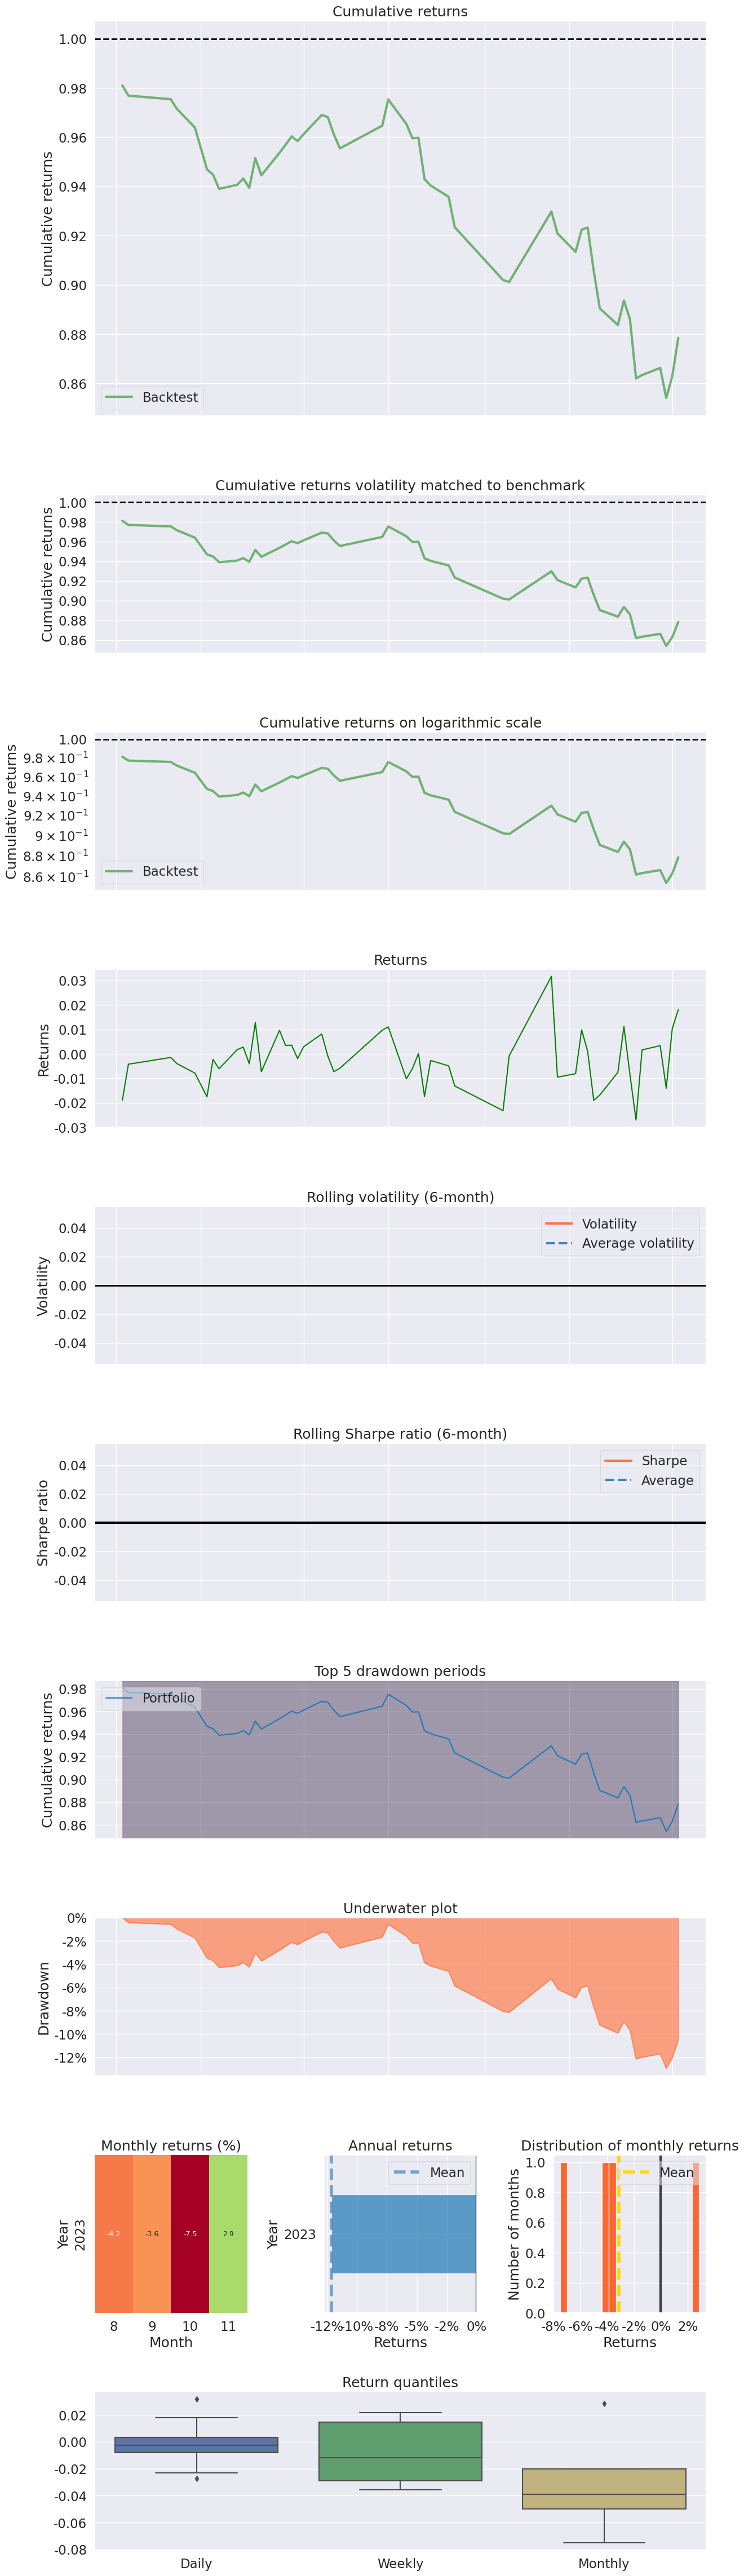

In [130]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [1.0, 0.0, 0.0]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2023-08-02
End date,2023-11-02
Total months,2
,Backtest
Annual return,0.5%
Cumulative returns,0.1%
Annual volatility,21.1%
Sharpe ratio,0.13
Calmar ratio,0.07
Stability,0.25
Max drawdown,-7.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.68,2023-08-03,2023-09-06,2023-10-19,56
1,4.76,2023-10-23,2023-11-02,NaT,NaN
2,0.00,2023-08-02,2023-08-02,2023-08-02,1
3,0.00,2023-08-02,2023-08-02,2023-08-02,1
4,0.00,2023-08-02,2023-08-02,2023-08-02,1


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


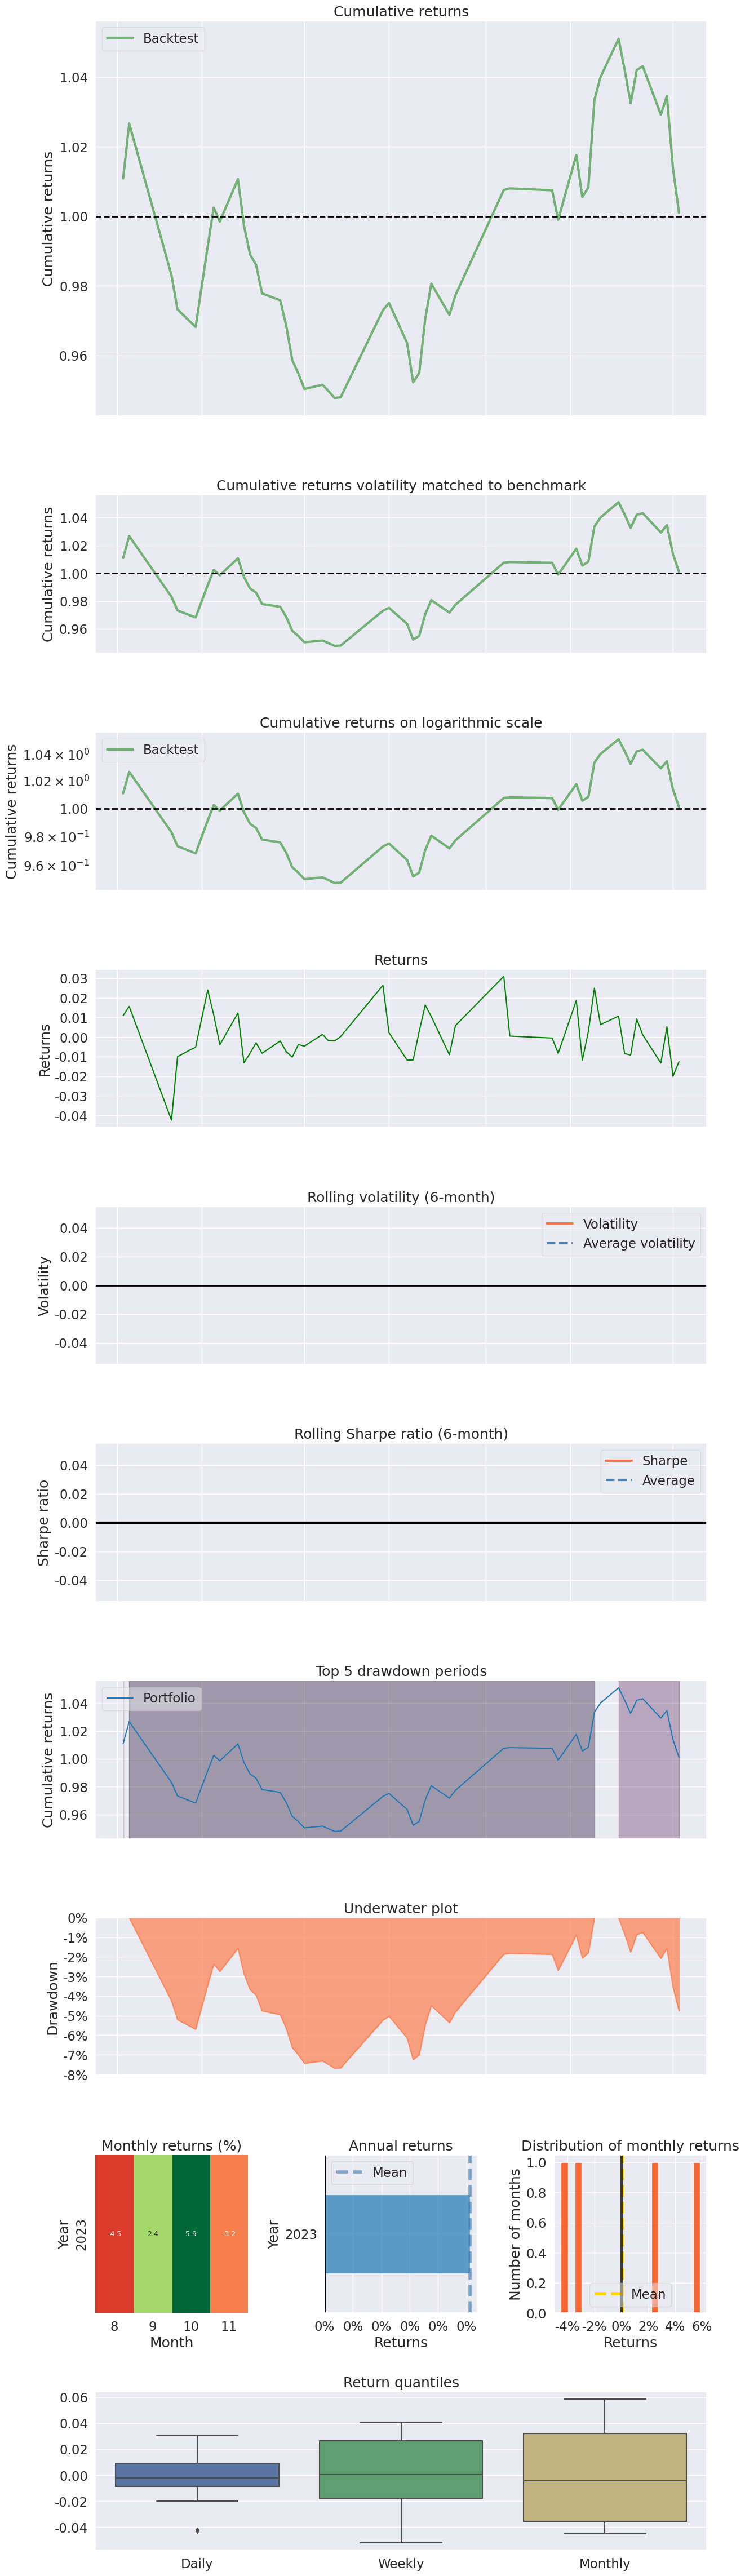

In [141]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.655, 0.0, 0.345]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2023-08-02
End date,2023-11-02
Total months,2
,Backtest
Annual return,28.0%
Cumulative returns,4.9%
Annual volatility,84.1%
Sharpe ratio,0.70
Calmar ratio,1.44
Stability,0.56
Max drawdown,-19.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.46,2023-08-21,2023-09-07,2023-09-18,21
1,14.45,2023-10-30,2023-11-02,NaT,NaN
2,12.19,2023-10-04,2023-10-05,2023-10-16,9
3,8.46,2023-08-02,2023-08-03,2023-08-21,14
4,6.09,2023-10-23,2023-10-25,2023-10-26,4


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


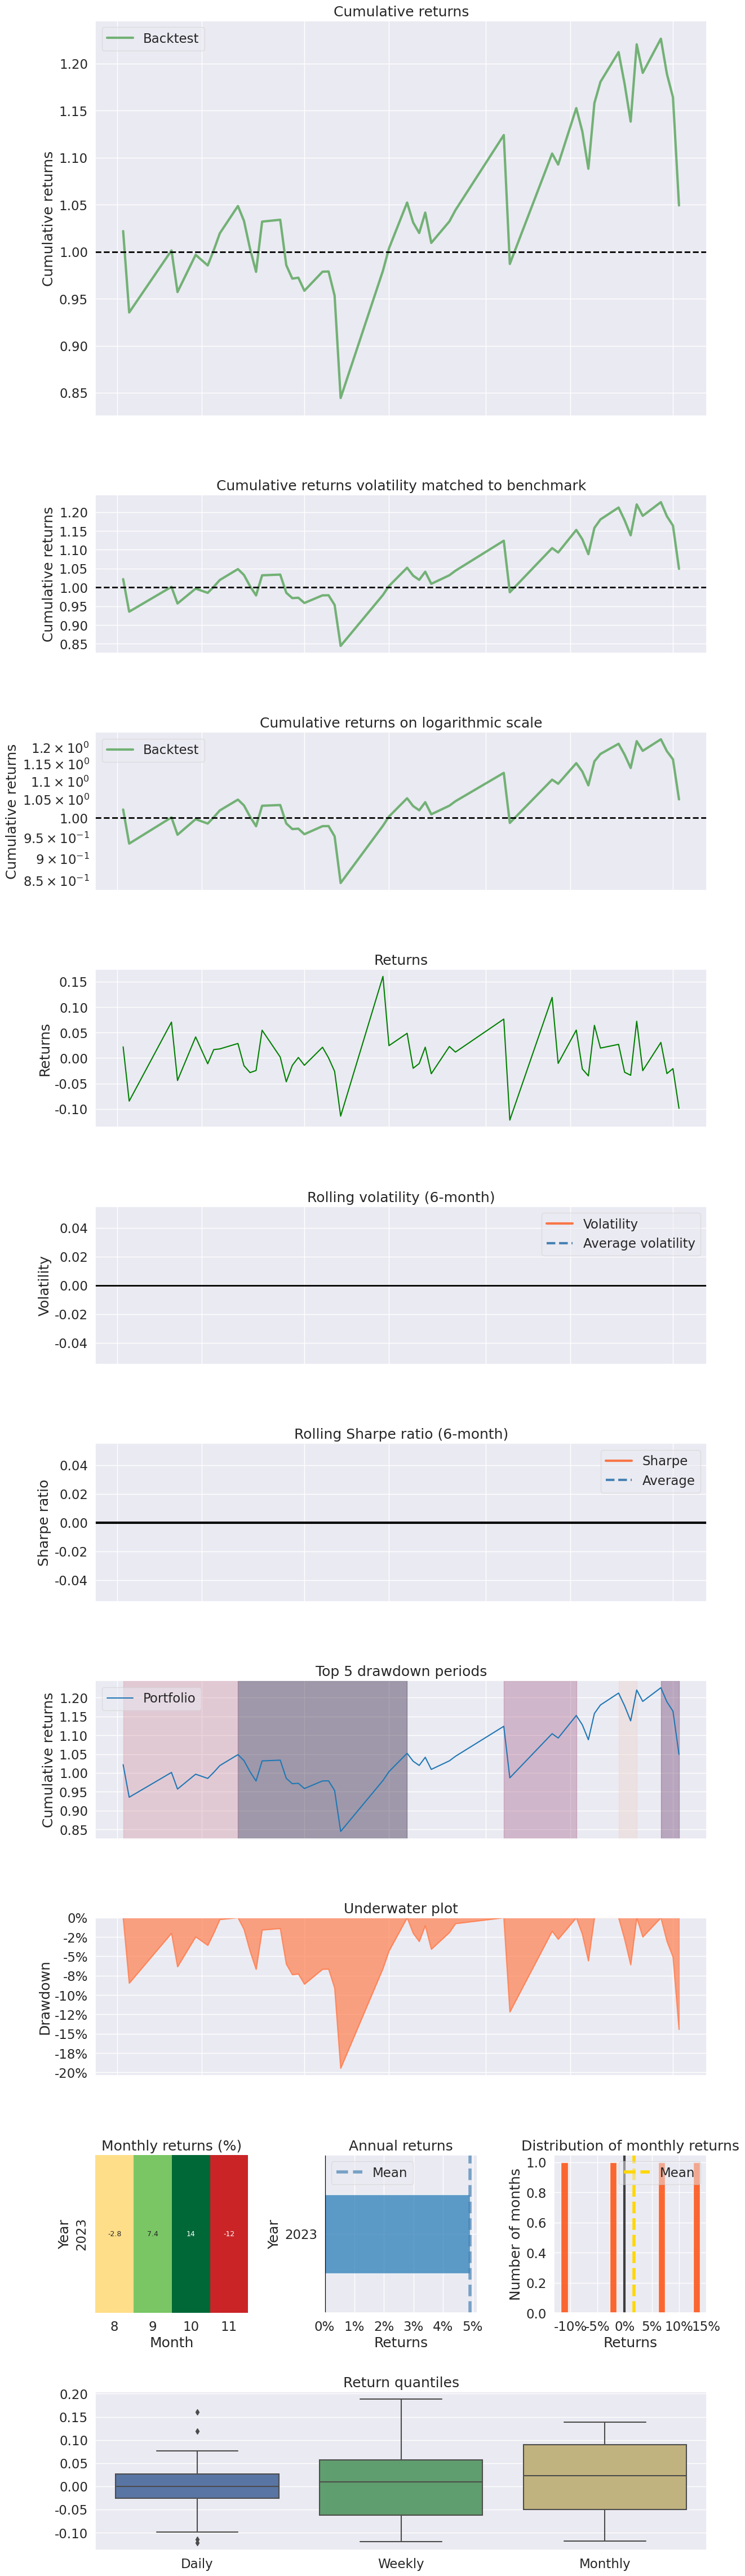

In [138]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.7, 0.3, 0.0]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2023-08-02
End date,2023-11-02
Total months,2
,Backtest
Annual return,0.4%
Cumulative returns,0.1%
Annual volatility,21.1%
Sharpe ratio,0.12
Calmar ratio,0.06
Stability,0.36
Max drawdown,-7.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.14,2023-08-21,2023-09-07,2023-10-04,33
1,5.39,2023-10-23,2023-11-02,NaT,NaN
2,3.63,2023-08-03,2023-08-11,2023-08-21,13
3,1.60,2023-10-04,2023-10-05,2023-10-12,7
4,1.32,2023-10-16,2023-10-18,2023-10-19,4


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


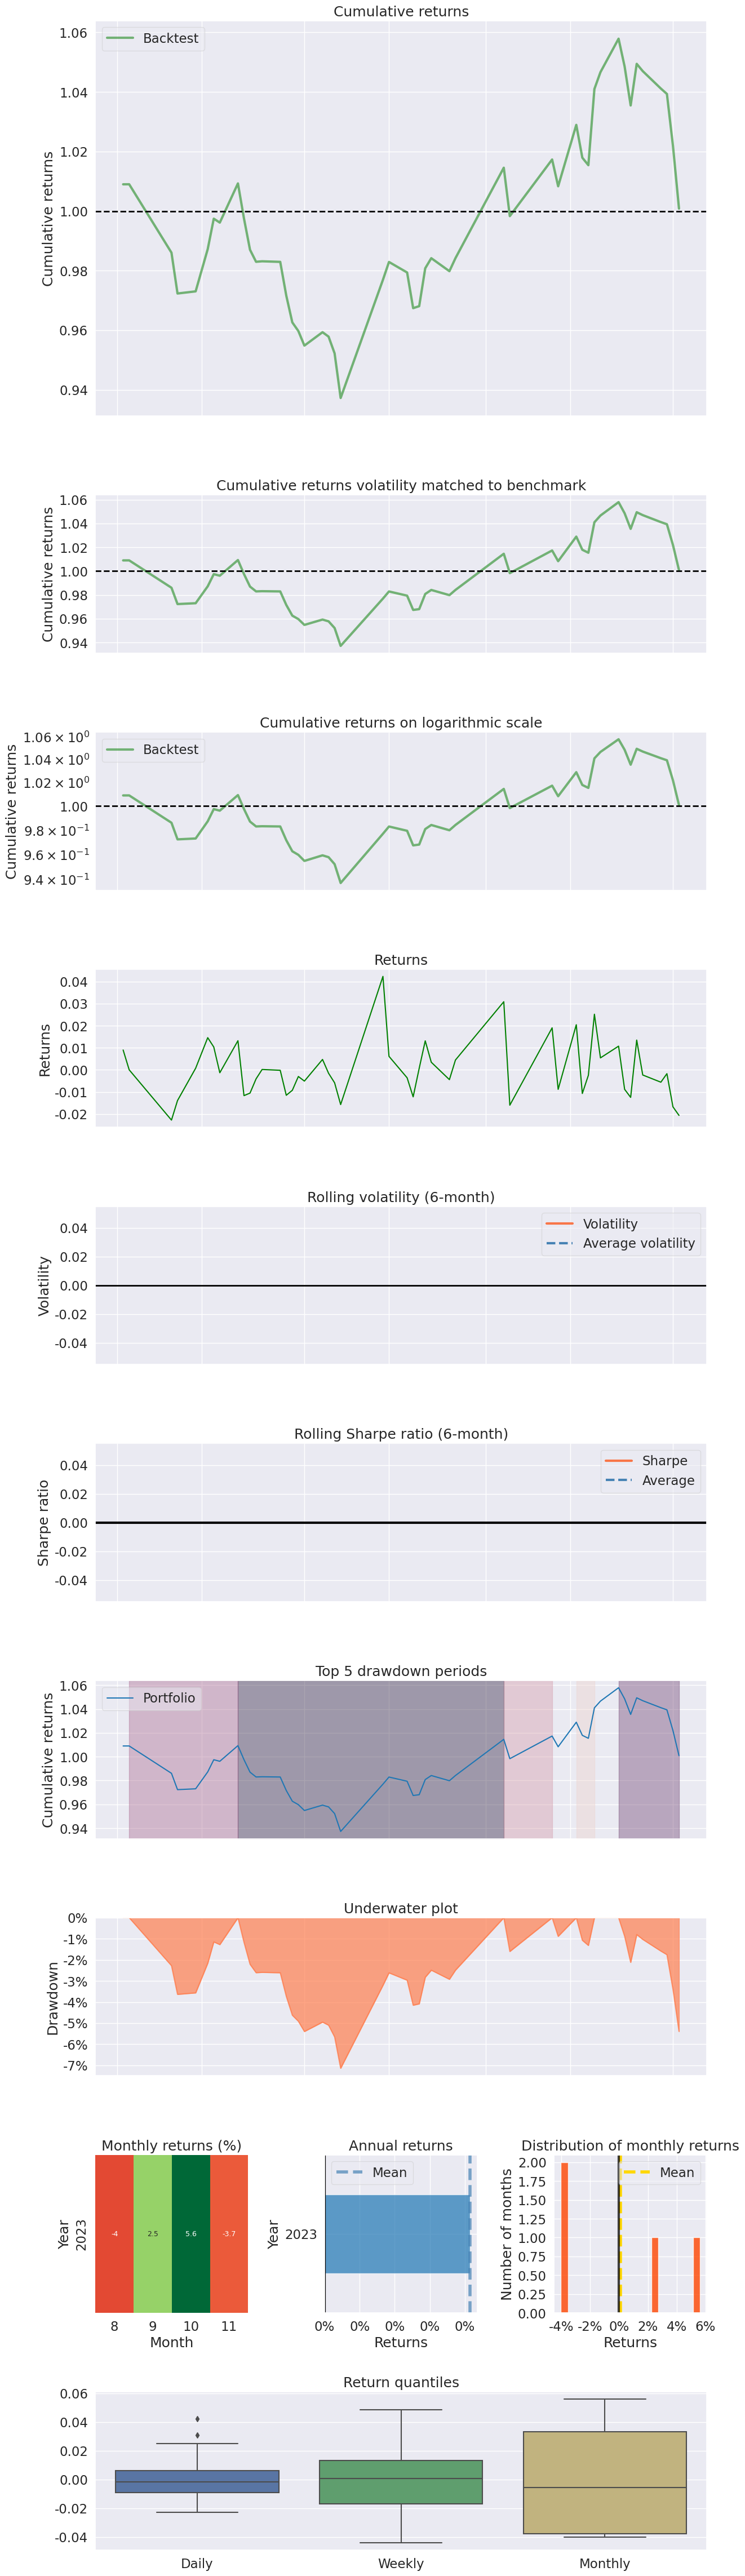

In [134]:
returns = df[['kospi_returns', 'w_vix_returns', 'vix_returns']]
portfolio_weights = [0.7, 0.04, 0.26]

portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                              index=df.index)

pf.create_returns_tear_sheet(returns=portfolio_returns)